# Jankbench benchmark on Android

Most devices today refresh their screens 60 times a second. If there’s an animation or transition running, or the user is scrolling, applications need to match the device’s refresh rate and put up a new picture, or frame, for each of those screen refreshes.
When one fails to meet this budget - 16.6 ms, the frame rate drops, and the content judders on screen. This is often referred to as jank, and it negatively impacts the user's experience.

This benchmark is used to count the jank frames for different types of activities: list and image list view fling, text render, text editing, etc. Also **ftraces** are captured during the benchmark run and represented at the end of the notebook.

In [1]:
from conf import LisaLogging
LisaLogging.setup()

2017-03-06 12:22:49,689 INFO    : root         : Using LISA logging configuration:
2017-03-06 12:22:49,689 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Get workload
    wload = Workload.getInstance(te, 'Jankbench')
    
    # Run Jankbench workload
    wload.run(te.res_dir, test_name='list_view', iterations=1, collect='ftrace')
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'android',
    "board"        : 'pixel',
    
    # Device
    "device"       : "FA6A10306347",
    
    # Android home
    "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",

    # Folder where all the results will be collected
    "results_dir" : "Jankbench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2017-03-06 12:22:55,673 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2017-03-06 12:22:55,674 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-03-06 12:22:55,674 INFO    : TestEnv      : External tools using:
2017-03-06 12:22:55,675 INFO    : TestEnv      :    ANDROID_HOME: /home/vagrant/lisa/tools/android-sdk-linux/
2017-03-06 12:22:55,675 INFO    : TestEnv      :    CATAPULT_HOME: /home/vagrant/lisa/tools/catapult
2017-03-06 12:22:55,675 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq']
2017-03-06 12:22:55,676 INFO    : TestEnv      : Connecting Android target [FA6A10306347]
2017-03-06 12:22:55,676 INFO    : TestEnv      : Connection settings:
2017-03-06 12:22:55,676 INFO    : TestEnv      :    {'device': 'FA6A10306347'}
2017-03-06 12:22:55,807 INFO    : android      : ls command is set to ls -1
2017-03-06 12:22:56,369 INFO    : TestEnv      : Initializing target workdir:
2017-03-06 12:22:56,372 INFO    : TestEnv      :    /da

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Jankbench - list view fling** experiment.

In [6]:
# Intialize Workloads for this test environment
results = experiment()

2017-03-06 12:23:01,463 INFO    : Workload     : Supported workloads available on target:
2017-03-06 12:23:01,466 INFO    : Workload     :   vellamo, youtube, jankbench, uibench, geekbench
2017-03-06 12:23:04,489 INFO    : Screen       : Force manual orientation
2017-03-06 12:23:04,491 INFO    : Screen       : Set orientation: PORTRAIT
2017-03-06 12:23:05,278 INFO    : Jankbench    : am start -n "com.android.benchmark/.app.RunLocalBenchmarksActivity" --eia "com.android.benchmark.EXTRA_ENABLED_BENCHMARK_IDS" 0 --ei "com.android.benchmark.EXTRA_RUN_COUNT" 1
2017-03-06 12:23:05,659 INFO    : Jankbench    : adb -s FA6A10306347 logcat ActivityManager:* System.out:I *:S BENCH:*
2017-03-06 12:23:05,825 INFO    : Jankbench    : FTrace START
2017-03-06 12:23:40,925 INFO    : Jankbench    :    Mean:  43.012 JankP:   0.061 StdDev:  40.420 Count Bad:    3 Count Jank:    1
2017-03-06 12:23:42,406 INFO    : Jankbench    : FTrace STOP
2017-03-06 12:23:47,926 INFO    : Screen       : Set orientation: 

## Results collection

In [7]:
def import_db(path):
    # Selection of columns of interest
    COLS = ['_id', 'name', 'run_id', 'iteration', 'total_duration', 'jank_frame']
    data = []
    db = '{}/{}'.format(te.res_dir, 'BenchmarkResults')
    conn = sqlite3.connect(db)
    for row in conn.execute('SELECT {} FROM ui_results'.format(','.join(COLS))):
        row = ('sched', ) + row
        data.append(row)
    print "DB[ {} ]: {:6d} rows imported".format('sched', len(data))
    return pd.DataFrame(data, columns=['test', ] + COLS)

df = import_db(te.res_dir)

DB[ sched ]:   1636 rows imported


## Benchmark plots and statistics

All the plots below represent total duration statistics for all the frames, in different ways.

In [8]:
def overall_statistics(df):
    byname_test = df.groupby(['name','test']).total_duration.describe(percentiles=[0.9, 0.95, 0.99])
    stats = pd.DataFrame(byname_test)
    # If using old Pandas, convert GroupBy.describe format to new version
    # http://pandas.pydata.org/pandas-docs/version/0.20/whatsnew.html#groupby-describe-formatting
    if 'count' not in stats.columns:
        stats = stats.unstack
    return stats

stats = overall_statistics(df)
stats

total_duration                                          \
                               count      mean       std       min       50%   
name            test                                                           
List View Fling sched         1636.0  4.653936  2.362408  2.953617  4.396287   

                                                               
                            90%       95%       99%       max  
name            test                                           
List View Fling sched  5.838117  6.405031  7.712081  88.78284

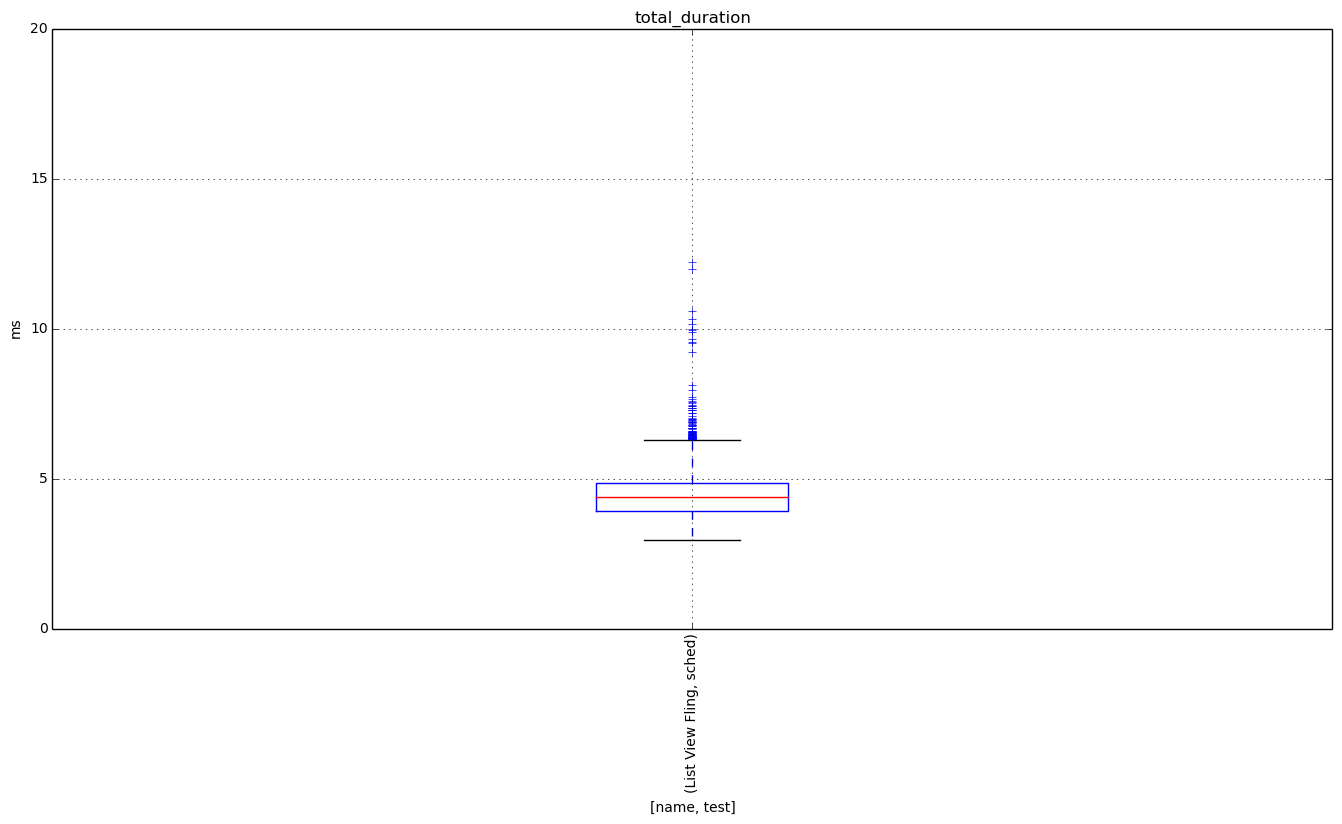

In [9]:
def total_duration_plot(data):
    fig, axes = plt.subplots(figsize=(16,8))
    bp = data.boxplot(by=['name','test'], column='total_duration', ax=axes, return_type='dict')
    fig.suptitle('')
    xlabels = [item.get_text() for item in axes.xaxis.get_ticklabels()]
    axes.set_xticklabels(xlabels, rotation=90)
    axes.set_ylim(0,20)
    axes.set_ylabel('ms');

total_duration_plot(data = df)

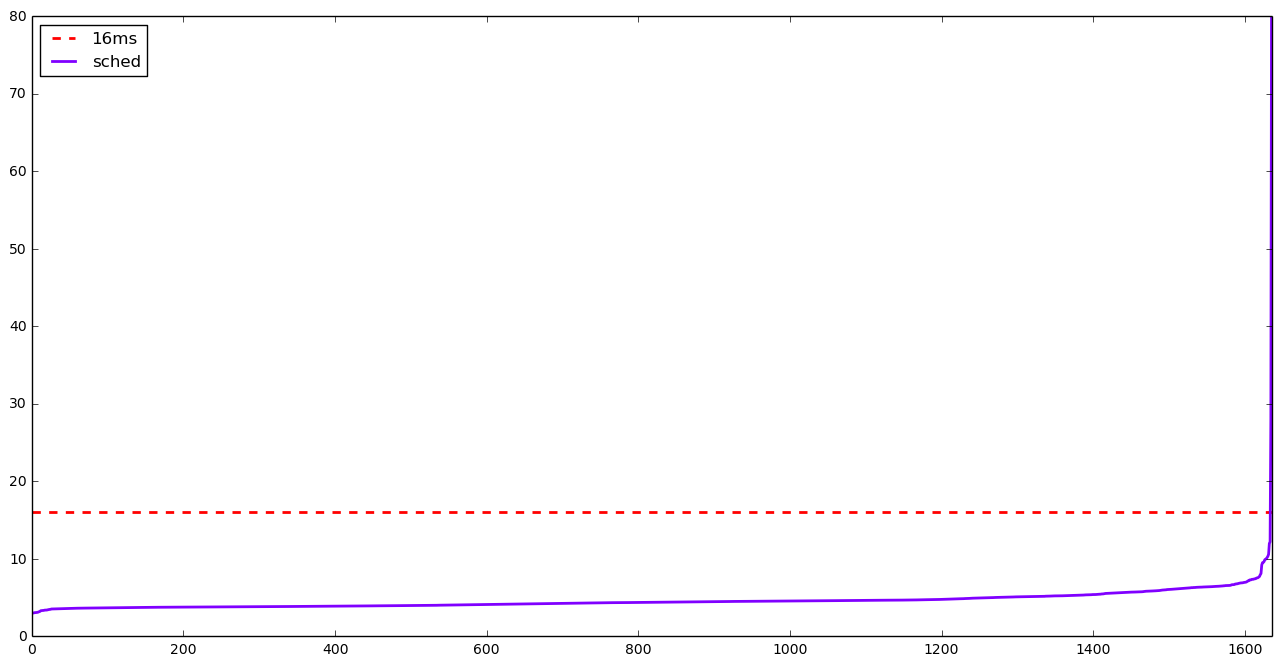

In [10]:
def total_duration_cumulative_distribution(df):
    fig, axes = plt.subplots()
    plt.axhline(y=16, linewidth=2, color='r', linestyle='--')
    colors = iter(cm.rainbow(np.linspace(0, 1, 1)))
    df = pd.DataFrame(sorted(df.total_duration))
    df.plot(
        figsize=(16,8),
        ax=axes,
        color=next(colors),
        linewidth=2,
        ylim=(0,80),
        legend=False);

    plt.legend(('16ms',) + tuple(['sched']), loc='best');
    
total_duration_cumulative_distribution(df)

## Traces - Latency analysis

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [11]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(trace_file, my_conf['ftrace']['events'], platform)

trappy.plotter.plot_trace(trace.ftrace)

2017-03-06 12:24:48,552 INFO    : Trace        : Platform clusters verified to be Frequency coherent


2017-03-06 12:25:09,241 WARNING : Analysis     : Multiple PIDs for task named [droid.benchmark]
2017-03-06 12:25:09,293 WARNING : Analysis     :   31805 :  droid.benchmark
2017-03-06 12:25:09,319 WARNING : Analysis     :   31957 :  AsyncTask #1,droid.benchmark
2017-03-06 12:25:09,320 WARNING : Analysis     : Returning stats only for PID: 31805
2017-03-06 12:25:09,379 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18
2017-03-06 12:25:09,380 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18
2017-03-06 12:25:09,380 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18
2017-03-06 12:25:09,397 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18
2017-03-06 12:25:09,605 INFO    : Analysis     : Found:  3495 WAKEUP latencies
2017-03-06 12:25:09,635 INFO    : Analysis     : Found:   319 PREEMPT latencies
2017-03-06 12:25:09,636 INFO    : Analysis     : Total:  3814 latency events
2017-03-06 12:25:09,63

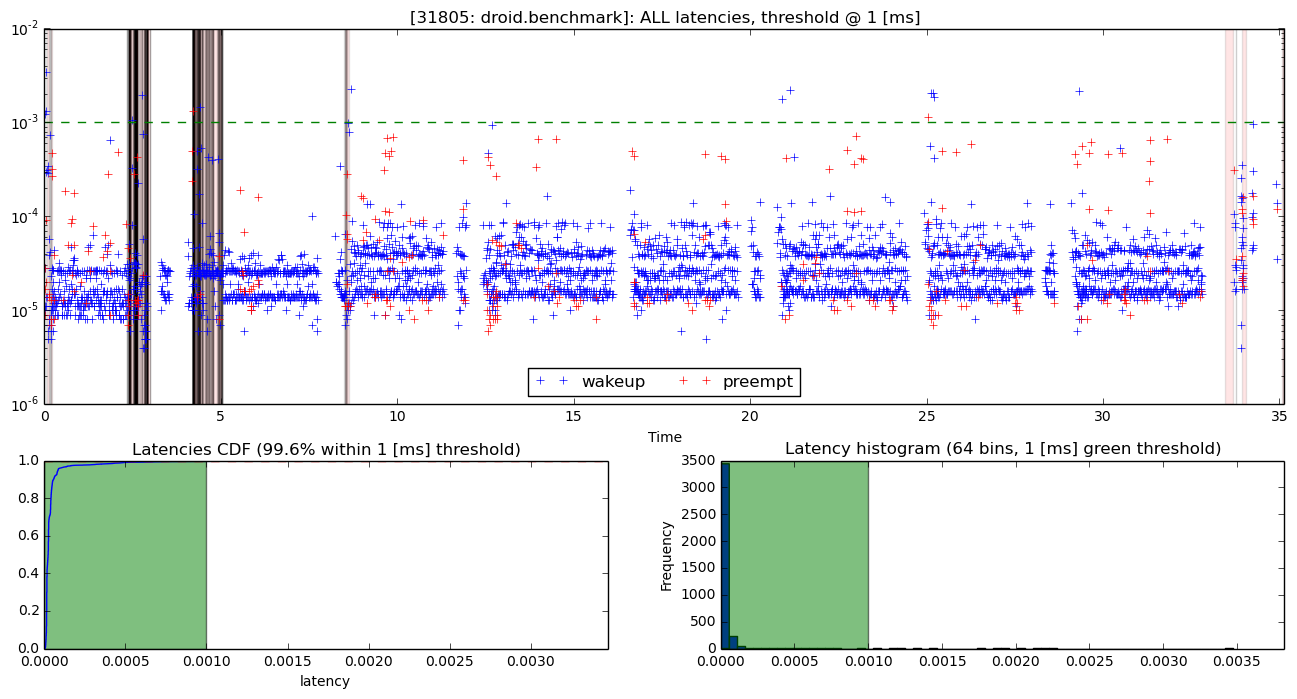

In [12]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('droid.benchmark')

2017-03-06 12:26:08,630 INFO    : Analysis     : LITTLE cluster average frequency: 1.152 GHz
2017-03-06 12:26:08,630 INFO    : Analysis     : big    cluster average frequency: 1.405 GHz


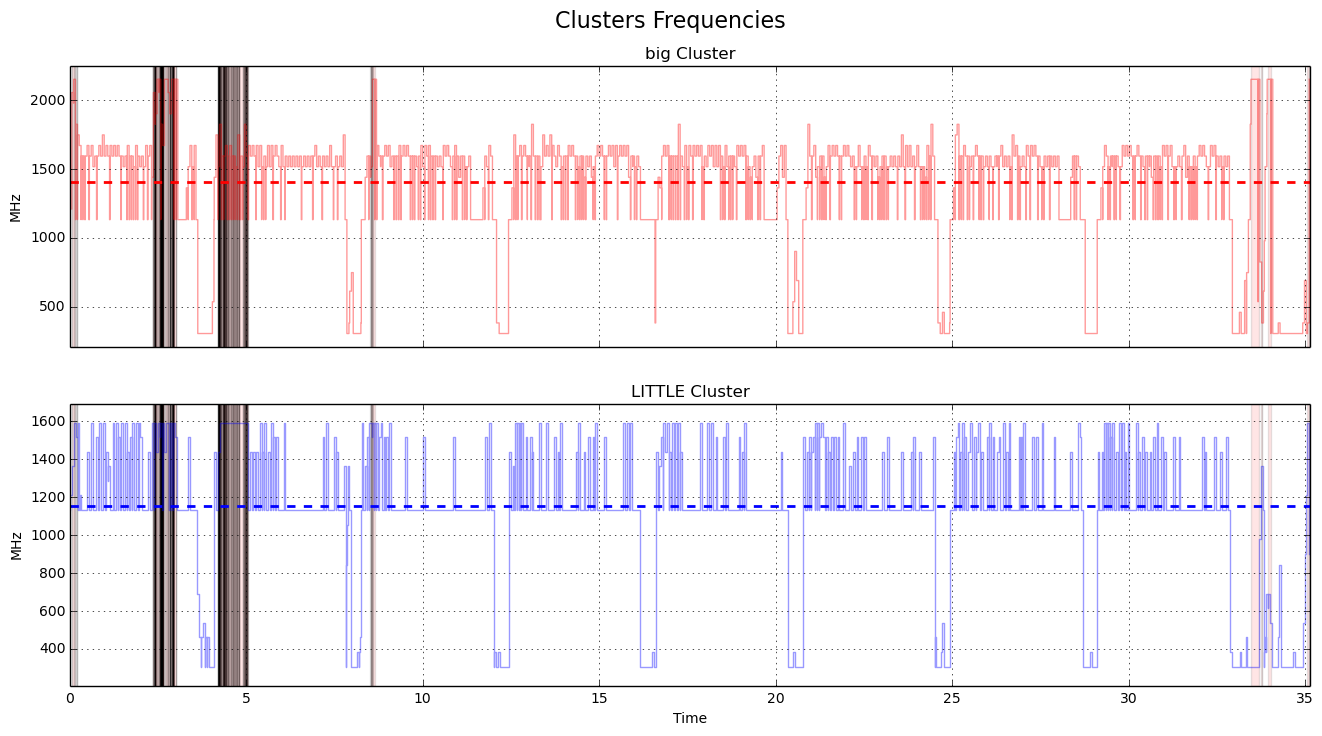

In [13]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass